# Data Wrangling Part 4 - Pandas Part 1

The following report was submitted as part of my Master of Data Science coursework on Data Wrangling. This report is the fourth in a five part series where I showcase work on various topics relating to Data Wrangling. This report is the first of two reports on the popular library Pandas. 

One important feature of this report is the discussion on missing data and the methods to identify and handle missing data. The quality of any analysis depends heavily on what data is available, so this topic is crucial for beginners wanting to improve their data analysis skills. 

## Working with *pandas* Data Frames (Heterogeneous Data)


&emsp; **Author:** Daniel Gladman <br>
&emsp; **Originally Written:** 2023-03-20 <br>

This report will use one of the datasets belonging to the well-known NYCFlights13 package. The weather dataset provides hourly weather observations throughout 2013 across three major New York City airports (JFK, LGA, and EWR). This dataset will be used to illustrate how the Pandas library is able to handle and seperate heterogeneous data (meaning data derivied from different independent sources), and provide insights directly relating to these sources individually. The data was downloaded and saved prior to begining the tasks in this report.

### Libraries

First the libraries used in this task shall be imported.

In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Pandas is a powerful external library that is built ontop of Numpy and is used primarily for data manipulation, analysis, and cleaning. Matplotlib and Seaborn shall be used to generate visual representations of the data. The datetime library is a native Python library that allows for working with dates and times. It offers a variety of functionalities for creating, manipulating, formatting, and comparing date and time objects.

#### Loading the Data
Next the data will be loaded.

In [2]:
import os

path = "./data/"
csv_filename = 'nycflights13_weather.csv'

if not os.path.isfile(os.path.join(path, csv_filename)):
    import gzip
    import csv
    filename = "nycflights13_weather.csv.gz"

    if os.path.isfile(os.path.join(path, filename)):

        # Open the gzipped file for reading
        with gzip.open(path+filename, 'rb') as f:
            # Open a new file for writing the decompressed contents to
            with open(path+csv_filename, 'w') as g:
                # Use the csv module to read the CSV data from the gzipped file
                reader = csv.reader(f.read().decode('utf-8').splitlines())
                # Use the csv module to write the CSV data to the output file
                writer = csv.writer(g)
                
                for row in reader:
                    if row and not row[0].startswith('#'):
                        writer.writerow(row)

    else:
        print("Error, please make sure that the file is downloaded and in the working directory")


df = pd.read_csv(path+csv_filename)        

df.head(5)

,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,0,37.04,21.92,53.97,230.0,10.35702,11.918651,0.0,1013.9,10.0,2013-01-01 01:00:00
1,EWR,2013,1,1,1,37.04,21.92,53.97,230.0,13.80936,15.891535,0.0,1013.0,10.0,2013-01-01 02:00:00
2,EWR,2013,1,1,2,37.94,21.92,52.09,230.0,12.65858,14.567241,0.0,1012.6,10.0,2013-01-01 03:00:00
3,EWR,2013,1,1,3,37.94,23.00,54.51,230.0,13.80936,15.891535,0.0,1012.7,10.0,2013-01-01 04:00:00
4,EWR,2013,1,1,4,37.94,24.08,57.04,240.0,14.96014,17.215830,0.0,1012.8,10.0,2013-01-01 05:00:00


Because the data file had been compressed using GZip, it requires decompression. There are other third party libraries such as patools, which can perform the decompression and extract the file in much less code,

 It is theoretically possible to perform the decompression and have Pandas read the file directly without writing a file, and this approach may be the wiser approach. There are parameters where the compression, delimiter among others can be explicitly stated when calling the read_csv method, however upon attempting to perform this on the present datafile, errors were encountered. So, it was decided that decompressing and writing the csv file prior to loading it would be the best approach.

 The result as shown above is the first 5 rows of the data. The next code segement will provide an overview of the data. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26130 entries, 0 to 26129
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   origin      26130 non-null  object 
 1   year        26130 non-null  int64  
 2   month       26130 non-null  int64  
 3   day         26130 non-null  int64  
 4   hour        26130 non-null  int64  
 5   temp        26129 non-null  float64
 6   dewp        26129 non-null  float64
 7   humid       26129 non-null  float64
 8   wind_dir    25712 non-null  float64
 9   wind_speed  26127 non-null  float64
 10  wind_gust   26127 non-null  float64
 11  precip      26130 non-null  float64
 12  pressure    23400 non-null  float64
 13  visib       26130 non-null  float64
 14  time_hour   26130 non-null  object 
dtypes: float64(9), int64(4), object(2)
memory usage: 3.0+ MB


There are 15 columns which encompass the following information

- origin: The weather station: LGA, JFK, or EWR, recorded as String objects.
- year, month, day, hour: The time of recording, recorded as 64-bit integers.
- temp,dewp: temperature and dewpoint in degrees Fahrenheit, recorded as 64-bit floating point numbers (decimal).
- humid: relative humidity, recorded as 64-bit floating point numbers (decimal).
- wind_dir, wind_speed, wind_gust: wind direction (in degrees), speed and gust speed (in mph), recorded as 64-bit floating point numbers (decimal).
- precip: precipitation, in inches, recorded as 64-bit floating point numbers (decimal)
- pressure: sea level pressure in millibars, recorded as 64-bit floating point numbers (decimal)
- visib: visibility in miles, recorded as 64-bit floating point numbers (decimal)
- time_hour: date and hour (based on the year, month, day, hour fields) formatted as YYYY-mm-ddHH:MM:SS, recorded as String Objects.

### Converting the Data to Metric

Because this is American sourced data, the measurements are all Imperial and must be converted into metric for non-American audiences. The first task will be to perform the conversion on the dataframe in place.

All conversions and their formula are provided below for convenience. 

[Fahrenheit to Celsius Formula](https://byjus.com/fahrenheit-to-celsius-formula/):

$$
^{\circ}C = (^{\circ}F-32) \times \frac{5}{9}
$$

[Inches to Millimetres Formula](https://www.inchcalculator.com/convert/inch-to-millimeter/)

$$
\text{millimeters} = \text{inches} \times 25.4
$$

[Miles to Kilometres Formula](https://www.inchcalculator.com/convert/mile-to-kilometer/)

$$
\text{kilometers} = \text{miles} \times 1.609344
$$

In [4]:
df.temp = (df.temp - 32) * (5/9)
df.dewp = (df.dewp - 32) * (5/9)
df.precip = df.precip * 25.4
df.visib = df.visib * 1.609344
df.wind_speed = df.wind_speed * 1.609344
df.wind_gust = df.wind_gust * 1.609344
df.head(5)

,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,0,2.8,-5.6,53.97,230.0,16.668008,19.181210,0.0,1013.9,16.09344,2013-01-01 01:00:00
1,EWR,2013,1,1,1,2.8,-5.6,53.97,230.0,22.224011,25.574947,0.0,1013.0,16.09344,2013-01-01 02:00:00
2,EWR,2013,1,1,2,3.3,-5.6,52.09,230.0,20.372010,23.443701,0.0,1012.6,16.09344,2013-01-01 03:00:00
3,EWR,2013,1,1,3,3.3,-5.0,54.51,230.0,22.224011,25.574947,0.0,1012.7,16.09344,2013-01-01 04:00:00
4,EWR,2013,1,1,4,3.3,-4.4,57.04,240.0,24.076012,27.706193,0.0,1012.8,16.09344,2013-01-01 05:00:00


The above code snippet has converted all the columns with imperical measurement into their metric counterparts. For example, the first row of the temperature has changed from 37.04 degrees Fahrenheit to 2.8 degrees celsius.

There is a bug in the data where the time_hour column is shifted forward by one hour.

In [5]:
df[['year', 'month', 'day', 'hour', 'time_hour']].head(5)

,year,month,day,hour,time_hour
0,2013,1,1,0,2013-01-01 01:00:00
1,2013,1,1,1,2013-01-01 02:00:00
2,2013,1,1,2,2013-01-01 03:00:00
3,2013,1,1,3,2013-01-01 04:00:00
4,2013,1,1,4,2013-01-01 05:00:00


So, as an additional task, a custom function will be defined to recreate the time_hour column with the correct time.

In [6]:
def toDatetime(row):
    """
    This function will take in a pandas dataframe row from the
    NYCFlights13 Weather dataset, extract the data from the
    year, month, day and hour columns and use them as inputs
    for the datetime method in python's datetime library.
    Returns a datetime object in format '%Y-%m-%d %H:%M:%S'
    
    """

    dt = datetime.datetime(year=row['year'], 
                           month=row['month'], 
                           day=row['day'], 
                           hour=row['hour'])
    return dt

# apply function 
df['time_hour_fixed'] = df.apply(lambda row: toDatetime(row), axis=1)

# Drop the original time_hour column.
df.drop("time_hour", axis=1, inplace=True)

df[['year', 'month', 'day', 'hour', 'time_hour_fixed']].head(5)

,year,month,day,hour,time_hour_fixed
0,2013,1,1,0,2013-01-01 00:00:00
1,2013,1,1,1,2013-01-01 01:00:00
2,2013,1,1,2,2013-01-01 02:00:00
3,2013,1,1,3,2013-01-01 03:00:00
4,2013,1,1,4,2013-01-01 04:00:00


First a custom function "toDatetime" is defined that passes a row value from the 'year', 'month', 'day', and 'hour' columns into the datetime method, which converts this information into a datetime object, which is a special type of object that happens to have the same format as the original time_hour value.

Then, this function is used within a lambda expression, which is a shorthand way to create a simple anonymous function that serves as the mechanism to pass a row from the dataframe into the toDatetime function and return the datetime object. 

Then, the pandas apply() method is used to apply the lambda expression to all rows of the Dataframe which creates an array of new datetime objects for all the rows in the dataframe. This can be assigned to a new column which has been labeled 'time_hour_fixed' while the original 'time_hour' column is removed from the dataframe in place.

The results above show that the time_hour_fixed column is now displaying the correct time stamp. This will be important for later tasks.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26130 entries, 0 to 26129
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   origin           26130 non-null  object        
 1   year             26130 non-null  int64         
 2   month            26130 non-null  int64         
 3   day              26130 non-null  int64         
 4   hour             26130 non-null  int64         
 5   temp             26129 non-null  float64       
 6   dewp             26129 non-null  float64       
 7   humid            26129 non-null  float64       
 8   wind_dir         25712 non-null  float64       
 9   wind_speed       26127 non-null  float64       
 10  wind_gust        26127 non-null  float64       
 11  precip           26130 non-null  float64       
 12  pressure         23400 non-null  float64       
 13  visib            26130 non-null  float64       
 14  time_hour_fixed  26130 non-null  datet

Also calling the df.info method confirms that this newly created column contains special datetime objects.

### Computing the Daily Average Precipitation from LGA airport

Next, the data will be filtered down to show only the rows that contain 'LGA' as its origin. From this slice of the data, the hourly precipitation data shall be aggregated into a daily format.

In [8]:
LGA_precip = df.loc[(df.origin == 'LGA'),['time_hour_fixed', 'precip']].copy()
LGA_precip_daily_mean = LGA_precip.groupby(df['time_hour_fixed'].dt.date)['precip'].mean()

LGA_precip_daily_mean.index.name = 'Date'
LGA_precip_daily_mean[:5]

Date
2013-01-01    0.0
2013-01-02    0.0
2013-01-03    0.0
2013-01-04    0.0
2013-01-05    0.0
Name: precip, dtype: float64

The above code first slices the dataset and makes a copy by explicitly calling a copy method. The will preserve the original dataset in its present form and prevent any inadverted changes to it.

To compute the daily precipitation averages, a string of methods are combined together into a statement that generates the desired outcome. 

First, the pandas groupby method is called, which groups all the rows within the 'time_hour_fixed' column using the pandas series method dt-date, or datetime-date. By calling dt-date, any datetime object can be parsed and filtered down to just a date representation. The result of this combination is that all rows will now be grouped by date creating a daily representation. This illustrates why it was important to fix the data earlier and convert the original time_hour data from string to datetime. This method would not work on string representations of dates as strings do not encode any information whereby the function can group them together.

Next, the 'precip' enclosed in square brackets is attached, which signals that the aggregation function that is to follow will be only applied to the precipitation column.

Then finally, the aggregation function is attached at the end, which in this case is .mean(). There are other aggregation functions according to the pandas documentation, such as median, min, max, sum... etc. The result above is a pandas series, which is analogous to a numpy array.

The column name, 'time_hour_fixed' is renamed 'date' for ease of interpretation.

### Plotting the results.

The above series can then easily be plotted in a graph.

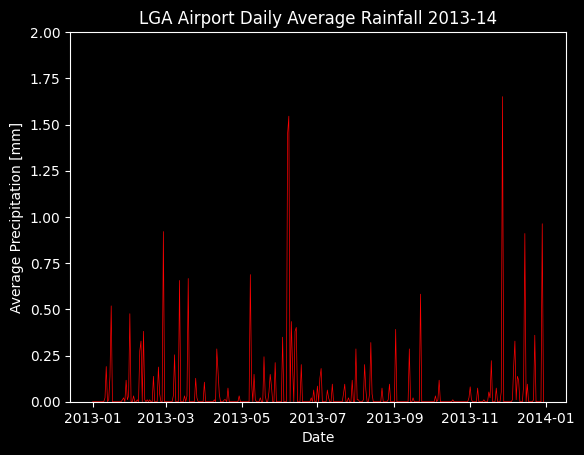

In [9]:
with plt.style.context('dark_background'):
    plt.plot(LGA_precip_daily_mean, c = 'r', lw=0.5)
    plt.title('LGA Airport Daily Average Rainfall 2013-14')
    plt.xlabel("Date")
    plt.ylabel("Average Precipitation [mm]")
    plt.ylim(0, 2)
    plt.show()

The above code takes the daily averages computed in the previous cell and generates a line graph. 

Computing the daily average smoothes the data out, making it easier to comprehend over longer timeframes. For instance, compare the daily average graph with a graph plotting the the hourly precipitation values.

Also, a dark theme was applied to the graph using matplotlib's style.coxtext() method. While it is better to stick to a consistent style throughout a report, different styles will be explored throughout the remainder of this report to illustrate different ways the visualizations can be presented.

8711


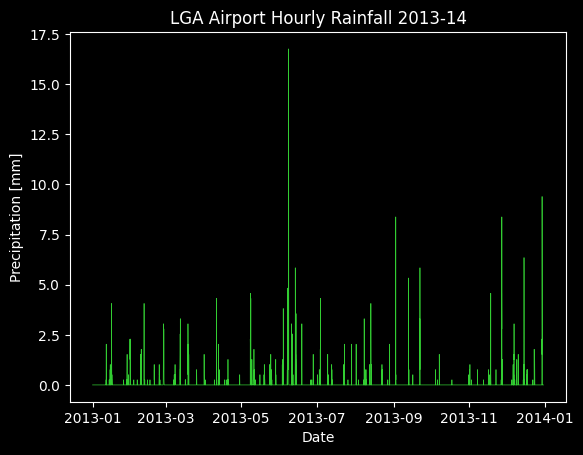

In [10]:
LGA = df.loc[(df.origin == 'LGA'),['time_hour_fixed', 'precip']].copy()
LGA.set_index('time_hour_fixed', inplace=True)
print(len(LGA))

with plt.style.context('dark_background'):
    plt.plot(LGA, c = '#32CD32', lw=0.5)
    plt.title('LGA Airport Hourly Rainfall 2013-14')
    plt.xlabel("Date")
    plt.ylabel("Precipitation [mm]")
    plt.show()

The hourly graph consists of 24 times the amount of datapoints, which makes the graph more difficult to decipher. It is possible to detect some abnormal hourly precipitation events from this graph, but overall the graph is less informative than the daily average graph.

Note, hexcodes for colours can be used giving greater flexibility for colour choice.

### Determining the 10 wettest days.

Next, the 10 wettest days will be identified using another pandas method.

In [11]:
LGA_precip_daily_mean.sort_values(ascending=False)[:10]

Date
2013-11-27    1.651000
2013-06-08    1.545167
2013-06-07    1.449917
2013-12-29    0.963083
2013-02-27    0.920750
2013-12-15    0.910167
2013-05-08    0.687917
2013-03-19    0.666750
2013-03-12    0.656167
2013-09-22    0.582083
Name: precip, dtype: float64

The pandas method sort_values() will return a sorted array of a column's values. By default this method will sort values in ascending order (smallest to largest). So, to ensure that the wettest day appears on top of the list, the ascending parameter can be set to False. Then to simplify the array and return only the top ten wettest days, a slice can be applied.

### Computing Daily Averages on multiple groups simultaneously.

In the previous example, the task was simplified by first creating a copy of just the LGA data, and then performing the grouping and aggregation functions on that subset.

This time, the daily humidity averages shall be computed for each airport; 'EWR', 'LGR' and 'JFK'.

In [12]:
grouped = df.groupby(['origin', pd.Grouper(key='time_hour_fixed', freq='D')])['humid'].mean()
grouped = grouped.reset_index()
grouped = grouped.rename(columns={'time_hour_fixed': 'date'})

The above code also utilizes the pandas.groupby method, but this time a list of parameters is passed into the method. First, is 'origin' which will create a first level grouping by 'EWR', 'LGR' and 'JFK'. Then, another pandas method 'Grouper()' is used to create a second level grouping by the datetime objects set at a frequency of 'D' meaning daily. The 'Grouper()' method is simply a generalized way of performing the same groupby sort performed earlier using the pandas series method dt-date. A comparison of the approaches shall be done later.

Then as before, the 'humid' column is specified in square brackets which signifies our desire to filter down to only the humidity column, and the final aggregation function are appended to the groupby() method.

The above code produces an output that creates a multi-index with two levels; origin and date. The problem with these arrangement is that while it is possible to perform further slices and sorting functions and plotting on this data, it requires more verbose instructions and functions to achieve the correct outcomes. So, by calling the reset_index() method, it is possible to convert this new grouped dataframe back into something resembling the original dataframe. In this format it is easier to create plots and filter the data. 

Finally, as before the pandas.rename() method is used to change the 'time_hour_fixed' column to date.

The below cells will show that for each airport, a daily humiditiy average has been computed.

In [13]:
grouped[(grouped.origin == 'EWR')].head(5)

,origin,date,humid
0,EWR,2013-01-01,58.386087
1,EWR,2013-01-02,47.786250
2,EWR,2013-01-03,54.395833
3,EWR,2013-01-04,55.880417
4,EWR,2013-01-05,49.284583


In [14]:
grouped[(grouped.origin == 'JFK')].head(5)

,origin,date,humid
364,JFK,2013-01-01,56.926087
365,JFK,2013-01-02,45.210417
366,JFK,2013-01-03,51.621667
367,JFK,2013-01-04,55.007917
368,JFK,2013-01-05,48.918750


In [15]:
grouped[(grouped.origin == 'LGA')].head(5)

,origin,date,humid
728,LGA,2013-01-01,53.085652
729,LGA,2013-01-02,49.521667
730,LGA,2013-01-03,53.791667
731,LGA,2013-01-04,49.524583
732,LGA,2013-01-05,46.331250


Note the behaviour of the index numbers, as they illustrate how each group is stacked ontop of each other in the data.

#### Testing the performance of Grouper() 

As an additional exploratory experiment, the performance of grouping the datetime objects by the pandas.Grouper() method shall be compared with grouping by the dt.date method.

As discussed earlier, the same outcome can be achieved using dt.date. See the below code.

In [16]:
grouped2 = df.groupby(['origin', df['time_hour_fixed'].dt.date])['humid'].mean()
grouped2 = grouped.reset_index()
grouped2 = grouped.rename(columns={'time_hour_fixed': 'date'})

Note the outcome of the first 5 rows of the pd.Grouper() method.

In [17]:
grouped.head()

,origin,date,humid
0,EWR,2013-01-01,58.386087
1,EWR,2013-01-02,47.786250
2,EWR,2013-01-03,54.395833
3,EWR,2013-01-04,55.880417
4,EWR,2013-01-05,49.284583


And note the outcome of the first 5 rows of the dt.date approach.

In [18]:
grouped2.head()

,origin,date,humid
0,EWR,2013-01-01,58.386087
1,EWR,2013-01-02,47.786250
2,EWR,2013-01-03,54.395833
3,EWR,2013-01-04,55.880417
4,EWR,2013-01-05,49.284583


Given the outputs appear identical, lets test the performance of each snippet.

In [19]:
%%timeit
grouped = df.groupby(['origin', pd.Grouper(key='time_hour_fixed', freq='D')])['humid'].mean()
grouped = grouped.reset_index()
grouped = grouped.rename(columns={'time_hour_fixed': 'date'})

8.62 ms ± 449 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%%timeit
grouped2 = df.groupby(['origin', df['time_hour_fixed'].dt.date])['humid'].mean()
grouped2 = grouped.reset_index()
grouped2 = grouped.rename(columns={'time_hour_fixed': 'date'})

6.39 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The results of the experiement show that the performance between approaches is very similar, with the Grouper() method appearing slightly faster overall, but the difference is negligible. Whichever approach one deems superior will come down to personal preference, but it can be argued that the readibility of the Grouper() method is better than the dt.date approach.

### Plotting the results.

The next task involves plotting the daily humidity averages for each airport on one single graph.

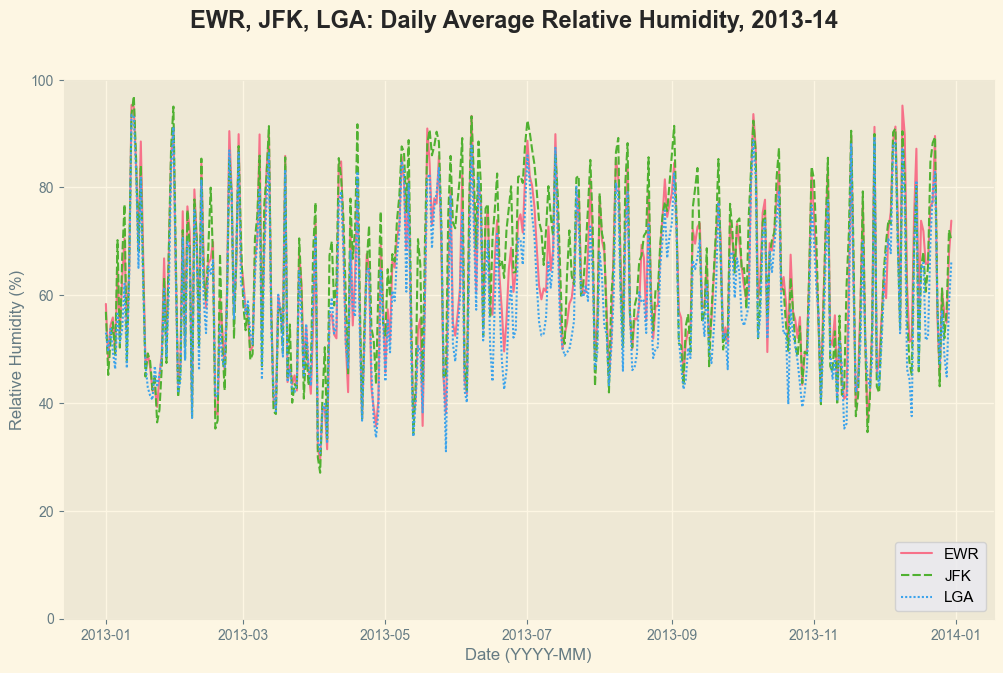

In [21]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(12, 7))
    sns.set_theme()
    ax = sns.lineplot(grouped, 
                      x='date', 
                      y='humid', 
                      hue='origin', 
                      style='origin',
                      palette= 'husl')
    ax.set_xlabel("Date (YYYY-MM)")
    ax.set_ylabel("Relative Humidity (%)")
    ax.set_ylim(0,100)
    fig.suptitle("EWR, JFK, LGA: Daily Average Relative Humidity, 2013-14", 
             fontsize=17, fontweight='semibold')

    plt.legend(labelcolor='black', 
               loc = 'lower right')
    plt.show()

The humidity percentanges appear to move in lock step among the EWR, JFK and LGA airports. Given that these airports are within the same wider region, this would be expected. However there do appear to be some times where the peaks and troughs differ between the airports. For example, between May and September 2013, the relative humidity is lower at LGA than the other airports. 

While each airport is within the same wider region, each location would have its own micro-climate which can be influenced by characteristics unique to that location.

For instance [Duane, Pepin, Losleben & Hardy's 2008 article](https://www.tandfonline.com/doi/pdf/10.1657/1523-0430%2806-127%29%5BDUANE%5D2.0.CO%3B2#:~:text=On%20average%2C%20moisture%20availability%20(both,enhanced%20toward%20the%20mountain%20summit.)) titled General Characteristics of Temperature and Humidity Variability on Kilimanjaro, Tanzania documented the effect that elevation can have on relative humidity. Given that each airport will have its own topography, it is not surprising to see some variability between the airports.

### Identifying and Handling Missing Records through Interpolation

Finally, this report will investigate the impact that missing values can have on a dataset, and how sometimes a dataset can give the illusion that no data points are missing when there are indeed missing data.

For this example, a subset of the temperature data at JFK airport shall be taken and stored as a separate variable.

In [22]:
JFK_temp = df.loc[(df.origin == 'JFK'), ['time_hour_fixed', 'temp']].copy()
JFK_temp.rename(columns={'time_hour_fixed': 'time_hour'}, inplace=True)
JFK_temp.set_index('time_hour', inplace=True)
JFK_temp.tail(5)

,temp
time_hour,
2013-12-30 19:00:00,3.3
2013-12-30 20:00:00,2.2
2013-12-30 21:00:00,1.1
2013-12-30 22:00:00,0.0
2013-12-30 23:00:00,-1.1


Next, the pandas.isna() method is called to return a boolean array that labels blank (NaN) values as True.

In [23]:
JFK_temp.isna().sum()

temp    0
dtype: int64

By applying a sum() method, the number of True values can be added together, which provides a count of the number of blank values.

The results above show that there are no blank values. This is good as when there are blank values that means there are missing values in the data. However is the opposite true; does the fact that no blank values are present also mean that there are no missing values? 

The following segment will test the hypothesis that:

$ \text{no blank values} = \text{no missing values} $

In [24]:
date_list = pd.date_range(start='2013-01-01', end='2013-12-30', freq='H')
df_date_rng = pd.DataFrame(date_list, columns=['time_hour'])
df_date_rng.set_index('time_hour', inplace=True)
missing_dates = df_date_rng[~df_date_rng.index.isin(JFK_temp.index)]
missing_dates.head(5)

""
time_hour
2013-01-01 05:00:00
2013-02-21 05:00:00
2013-03-05 06:00:00
2013-03-31 01:00:00
2013-04-03 00:00:00


To test this hypothesis, a dummy dataframe that consists of all possible hour timestamps between 01-01-2013 and 30-12-2013 which is the last date in the JFK_temp data.

This can be achieved by calling the pandas.date_range() method, which can be used to create an array of datetime objects. Setting the 'freq' (frequency) to 'H' will create hourly timestamps. This array can then be converted into a dataframe.

The idea behind creating this dummy dataframe is that it will allows us to look for mismatches between the dummy timestamps and the JFK_temp data. This can be achieved by utilizing the pandas.isin() method which checks to see if all unique values appear in anoter series of values. Because all timestamps are unique, this method is appropriate in this case. We can test our hypothesis by using the logic:

$\begin{aligned} 
\text{dummy dates not in JFK\_temp}
\end{aligned}$

The result is stored in a variable missing dates, which contains a list of timestamps. These are the timestamps that do not appear in JFK_temp, meaning that there are missing entries in the data. The hypothesis that no blank entries is equivalent to no missing entries is not confirmed. This is crucial when dealing with large datasets, because it is difficult discern whether missing values exist by inspecting the dataframe.

The impact that these missing values have should not be dismissed outright. The previous tasks have been performed on the assumption that no missing values exist in the data. When daily aggregations are computed on hourly data, it is expected that each daily average will consist of $n=24$ entries. Any aggregated mean with $n\lt24$ entires means that the aggregated mean cannot be trusted to the same extent.

Now that it has been determined that there are missing values in the data, we will update the JFK_temp dataframe to incorporate this missing values.

In [25]:
JFK_temp = pd.merge(left=df_date_rng, right=JFK_temp, on='time_hour', how='left')
JFK_temp.isna().sum()

temp    25
dtype: int64

In [26]:
JFK_temp[JFK_temp.temp.isna()].head(5)

,temp
time_hour,
2013-01-01 05:00:00,NaN
2013-02-21 05:00:00,NaN
2013-03-05 06:00:00,NaN
2013-03-31 01:00:00,NaN
2013-04-03 00:00:00,NaN


The pandas.merge() method is called to join these two dataframes together. The two dataframes are passed into the method and the column where the join should be applied is passed as the 'on' argument. Finally, the type of join is passed as the 'how' argument. A left join means that only the keys from left frame are preserved, including their order. Because the dummy dataframe contains the totality of all possible timestamps, this dataframe will be the left dataframe.

Running the isna().sum() methods shows that there are now 25 missing entries in the dataframe.

Note, it is possible to call the .merge() method directly on the dataframe that is to be the 'left' dataframe. A quick performance test was conducted.

In [27]:
%%timeit
df_date_rng.merge(JFK_temp, how='left', on='time_hour')

1.58 ms ± 42.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
%%timeit
pd.merge(df_date_rng, JFK_temp, on='time_hour', how='inner')

1.42 ms ± 60.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Both implementations of the method performed as well as each other. For clarity, exlicitly stating pd.merge and stating both dataframes may be a better approach, but it comes down to subjective preference.

#### Interpolating Data

Now that we have uncovered the hidden missing values in the data, what is to be done with them? As it is impossible to go back in time and collect the true values, it is possible to use the known data to estimate the unknown data. This is refered to as interpolation. 

There are a number of approaches that can be used to interpolate, however in this example we are tasked with using a linear interpolation method which ensures that all estimated values are equally spaced. 

For example, if there were a sequence of $[10, NaN, NaN, 40, 50]$, a linear interpolation would result in $[10, 20, 30, 40, 50]$. Here the 20 and 30 are computed from their nearest neighbours, 10 and 40.

Next, the missing values will be estimated.

In [29]:
JFK_temp['interpolate_temp'] = JFK_temp['temp'].interpolate(method='linear')
JFK_temp.isna().sum()

temp                25
interpolate_temp     0
dtype: int64

In [30]:
JFK_temp[JFK_temp.index.isin(missing_dates.index)].head(5)

,temp,interpolate_temp
time_hour,,
2013-01-01 05:00:00,NaN,3.90
2013-02-21 05:00:00,NaN,-3.60
2013-03-05 06:00:00,NaN,0.30
2013-03-31 01:00:00,NaN,5.85
2013-04-03 00:00:00,NaN,5.00


Fortunately the pandas.interpolate() method can be used to solve our missing value problem. The default method is 'linear' but it is included in the code above for ease of reference. These values are then added to a new column labelled 'interpolate_temp'. The 25 missing values present in the 'temp' column are now no longer there.

#### Assessing the impact of interpolation.

We have now computed some arteficial data, but what impact will these arteficial data have on the daily averages?

To address this question, the daily temperature average will be computed for both the original and interpolated data.

In [31]:
daily_avg_temp = JFK_temp.resample('D').mean()
daily_avg_temp.index.name = 'date'
daily_avg_temp.head(5)

,temp,interpolate_temp
date,,
2013-01-01,3.817391,3.820833
2013-01-02,-1.920833,-1.920833
2013-01-03,-1.237500,-1.237500
2013-01-04,1.129167,1.129167
2013-01-05,2.720833,2.720833


Here another pandas method is used to perform the aggregation; pandas.resample(). When the JFK_temp was created earlier, the dataframe indices were set as the 'time_hour' timestamps. In this instance, the resample() method is useful for when the indices are datetime objects. This method frequently appears in quantitative finance with python textbooks. The resample() method can still be used even if the indices are non-datetime objects, but a column consisting of datetime objects must exist and passed into the method as a parameter.

The outcome is identical to the Grouper() method demonstrated earlier.

In [32]:
JFK_temp.groupby(pd.Grouper(freq='D')).mean().head(5)

,temp,interpolate_temp
time_hour,,
2013-01-01,3.817391,3.820833
2013-01-02,-1.920833,-1.920833
2013-01-03,-1.237500,-1.237500
2013-01-04,1.129167,1.129167
2013-01-05,2.720833,2.720833


A quick performance test was done on these methods.

In [33]:
%%timeit
JFK_temp.resample('D').mean()

643 µs ± 15.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [34]:
%%timeit
JFK_temp.groupby(pd.Grouper(freq='D')).mean()

564 µs ± 12.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Both approaches are quick, however the Grouper() method is quicker than the resample method. However the resamle method is simpler to write, more concise, and perhaps a little easier to understand.

Finally, the differences between the interpolated average and the original average were computed and plotted on a bar chart.

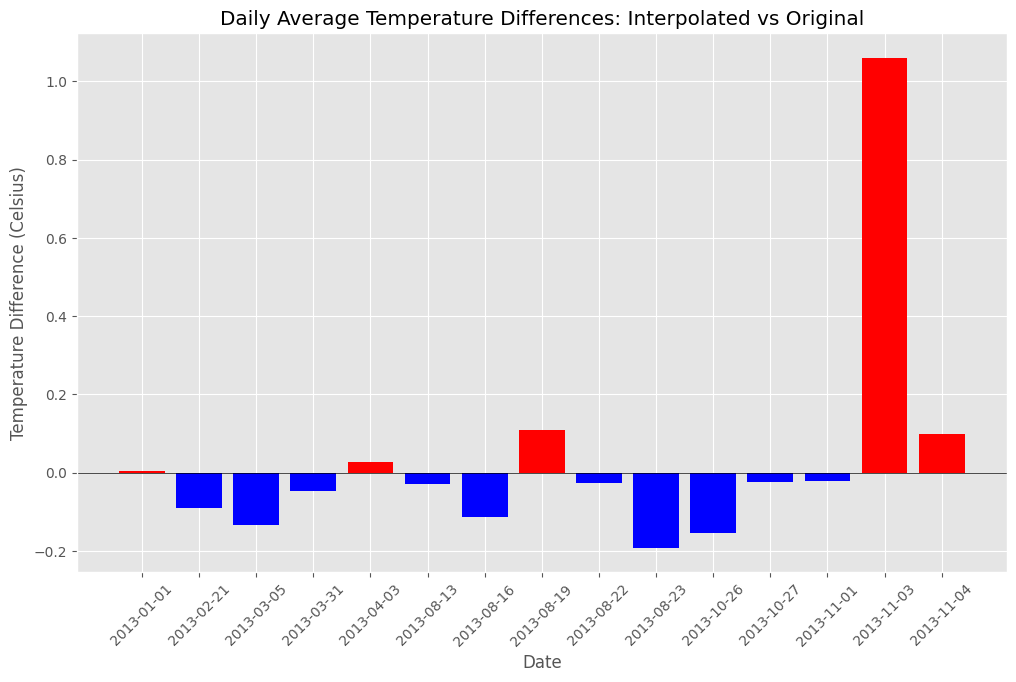

In [35]:
daily_avg_temp['temp_diff'] = daily_avg_temp.interpolate_temp - daily_avg_temp.temp
differences = daily_avg_temp[daily_avg_temp.temp_diff != 0]['temp_diff'].copy()
differences.index = differences.index.astype('str')
differences

with plt.style.context('ggplot'):
    colours = ['red' if diff > 0 else 'blue' for diff in differences]
    fig, ax = plt.subplots(figsize=(12, 7))
    plt.bar(differences.index, differences, color = colours)
    plt.axhline(y=0, color='black', lw = 0.5)
    plt.xlabel('Date')
    plt.xticks(rotation = 45 )
    plt.ylabel('Temperature Difference (Celsius)')
    plt.title('Daily Average Temperature Differences: Interpolated vs Original')
    plt.show()

The results show that as expected, adding additional datapoints shifted the computed averages. However the direction of the shift varied. The positive differences, in red, refer to when the interpolated values shifted the mean higher, while negative differences, in blue, refer to when the interpolated values shifted the mean lower. It is important to note that there were some instances where no difference was observed, as the original number of missing values was 25, while the number of differences $\ne$ 0 was 15.

When there were differences between the interpolated and original averages they were modest; the majority ranging between 0 and 0.2 degrees celsius. However, for one of the entries the interpolated average shifted higher by more than 1 degree celsius. The following snippets shall investigate this difference further. It is expected that a higher proportion of missing values occured within this 24 hour timespan.

In [36]:
start_datetime = datetime.datetime.strptime('2013-11-03 00:00:00', '%Y-%m-%d %H:%M:%S')
end_datetime = datetime.datetime.strptime('2013-11-03 23:00:00', '%Y-%m-%d %H:%M:%S')

JFK_temp[(JFK_temp.index >= start_datetime) & (JFK_temp.index <= end_datetime)]

,temp,interpolate_temp
time_hour,,
2013-11-03 00:00:00,NaN,15.95
2013-11-03 01:00:00,NaN,15.20
2013-11-03 02:00:00,NaN,14.45
2013-11-03 03:00:00,NaN,13.70
2013-11-03 04:00:00,NaN,12.95
2013-11-03 05:00:00,12.2,12.20
2013-11-03 06:00:00,11.1,11.10
2013-11-03 07:00:00,10.6,10.60
2013-11-03 08:00:00,10.6,10.60


In [37]:
start_datetime = datetime.datetime.strptime('2013-11-02 23:00:00', '%Y-%m-%d %H:%M:%S')
end_datetime = datetime.datetime.strptime('2013-11-03 05:00:00', '%Y-%m-%d %H:%M:%S')

JFK_temp[(JFK_temp.index >= start_datetime) & (JFK_temp.index <= end_datetime)]

,temp,interpolate_temp
time_hour,,
2013-11-02 23:00:00,16.7,16.70
2013-11-03 00:00:00,NaN,15.95
2013-11-03 01:00:00,NaN,15.20
2013-11-03 02:00:00,NaN,14.45
2013-11-03 03:00:00,NaN,13.70
2013-11-03 04:00:00,NaN,12.95
2013-11-03 05:00:00,12.2,12.20


As expected, there were five consecutive missing hourly entries occuring within 2013-11-03.
As the interpolated values were all higher than the maximum of the original values within this range, the average interpolated temperature increased. As a result, the daily interpolated average for this day is more reliable than the original data.

### Conclusion

In summary, this report used the pandas library to perform analysis on heterogeneous data. As pandas is built upon numpy, it benefits from the quick computational power that numpy provides. However, unlike numpy, Pandas is able to facilitate categorical data which provides addtional context to the numerical data, making the analysis more powerful.

The key takeaways from this report were: 
- the importance of ensuring that dataframes contain datetime objects rather than string representations of datetime when performing aggregation functions on time series data, 
- the importance of not assuming that no blank values is the same as having no missing values
- missing values need not be discarded

In general when it comes to data analysis, there are many benefits to having more samples than less samples. A few possible suggestions for further exploration would be to analyse the other airport data to check for missing values and recomputing the daily averages. 